In [94]:

import models
import utils
import data_processing
from constants import (
    VALUE_COLUMN,
    UNIT_RATE_COLUMN,
    QUANTITY_COLUMN,
    GROSS_WEIGHT_COLUMN,
    SHIP_COUNT_COLUMN,
    PORT_COUNT_COLUMN,
    FILL_METHOD,
    TARGET_COLUMN,
    VOLZA_COLUMNS,
    AIS_COLUMNS,
    OIL_COLUMNS,
    ARIMA_RESIDUAL_COLUMN,
    RANDOM_STATE
)
import pandas as pd
import constants
import sys
from datetime import datetime
from build_data import get_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt
import numpy as np

In [95]:
COMMODITY = "cobalt"
WINDOW_SIZE = 20

VOLZA_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}.csv"
PRICE_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}_prices.csv"

# Get the data
data = get_data(VOLZA_FILE_PATH, PRICE_FILE_PATH, window_size=WINDOW_SIZE, center=False)

# Add Isolation Forest spikes column
data['spikes_if'] = utils.detect_spikes_if(data, TARGET_COLUMN + VOLZA_COLUMNS, contamination=0.07)



Building data...


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={"Value": "Brent Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={"Value": "WTI Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inste

Rows dropped due to NaN values: 1
Detecting spikes... 20


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [96]:
import matplotlib.pyplot as plt

aggregated_df = data.copy()
data.head(2)

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if
1,2020-01-02,90209.765369,2300.0,0.0,39.903707,32355.0,67.05,61.17,32355.00000,0,0
2,2020-01-03,411.070686,10.0,0.0,41.107069,31850.0,69.08,63.00,-16915.55263,0,0


Spike Percentage: 7.04%


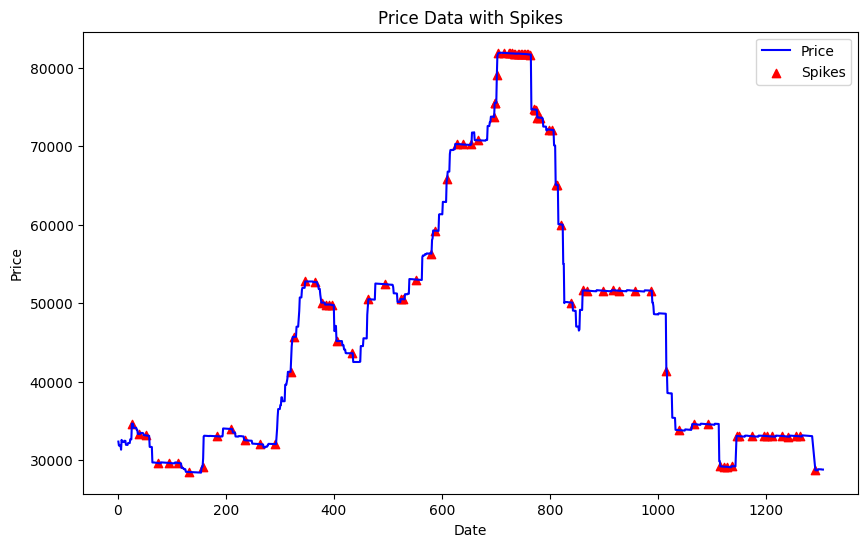

In [97]:
import matplotlib.pyplot as plt
# Plotting the price data
utils.plot_prices(aggregated_df,column='spikes_if')

In [98]:
PRICE_FEATURE_COLUMNS = ['ma_5', 'ma_10', 'returns']
PRICE_LAG_FEATURE_COLUMNS = ['lag_1', 'lag_2', 'lag_3']
PRICE_COLUMN = ['Price']
FEATURE_COLUMNS = PRICE_COLUMN
# PRICE_COLUMN = ['Price']
TARGET_COLUMN = ['spikes_if']

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Dropout, LayerNormalization, MultiHeadAttention, Input, LSTM, SimpleRNN
from tensorflow.keras.layers import Attention, Reshape
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os

def make_output_dict(name, params, classification_report, prior):
    return {
        "Name": name,
        "Params": params,
        "Accuracy": classification_report["accuracy"],
        "Precision (0)": classification_report["0"]["precision"],
        "Recall (0)": classification_report["0"]["recall"],
        "F1 (0)": classification_report["0"]["f1-score"],
        "Precision (1)": classification_report["1"]["precision"],
        "Recall (1)": classification_report["1"]["recall"],
        "F1 (1)": classification_report["1"]["f1-score"],
        "Prior": f"{prior:.2f}"
    }

def prior(y_test):
    total_spikes_in_test = np.sum(y_test == 1)
    total_data_points_in_test = y_test.shape[0]
    spike_percentage_in_test = (total_spikes_in_test / total_data_points_in_test) 
    return spike_percentage_in_test

#LSTM Model
def evaluate_lstm(num_layers: int, X_train, y_train, X_test, y_test):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(num_layers, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
  model.add(Dense(num_layers/2, activation='relu'))
  model.add(Dense(num_layers/2, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

  # Train the model
  model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

  y_pred = (model.predict(X_test) > 0.5).astype(int)
  output = make_output_dict(f"LSTM", f"{num_layers} layers", classification_report(y_test, y_pred, output_dict=True),prior(y_test))
  return y_pred, output

# Attention CNN
def create_acnn_model(input_shape, num_classes, filters, kernel_size):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(filters, kernel_size=kernel_size, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    # Calculate the new shape for dynamic reshaping
    conv_shape = conv1.shape.as_list()
    new_shape = (-1, conv_shape[1] * conv_shape[2] // 2)

    # Reshape for attention
    reshape = Reshape(new_shape)(pool1)

    # Attention mechanism
    attention = Attention()([reshape, reshape])

    # Flatten for fully connected layers
    flatten = Flatten()(attention)

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=outputs)

    return model

def evaluate_attention_cnn2(filters, kernel_size, X_train, y_train, X_test, y_test):
    model = create_acnn_model(X_train.shape[1:], 2, filters, kernel_size)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, batch_size=filters, verbose=False)
    y_pred = model.predict(X_test)
    output = make_output_dict("CNN with Attention", f"{filters} filters, kernel size {kernel_size}", classification_report(y_test, y_pred.argmax(axis=1), output_dict=True), prior(y_test))
    return y_pred, output

def save_predictions_to_file(model_name, y_pred, y_test, directory_path):
    try:
        os.makedirs(directory_path, exist_ok=True)

        # Check and adjust shapes. Flatten if 2D with one column, otherwise respect multi-dimensionality for multi-class
        if y_pred.ndim > 1 and y_pred.shape[1] == 1:
            y_pred = y_pred.flatten()
        if y_test.ndim > 1 and y_test.shape[1] == 1:
            y_test = y_test.flatten()

        # Handling for multi-class classification where y_pred is not 1-dimensional
        if y_pred.ndim > 1:
            # For multi-dimensional y_pred, create a DataFrame with a column for each class/label
            predictions_df = pd.DataFrame(y_pred, columns=[f'Predicted_{i}' for i in range(y_pred.shape[1])])
            predictions_df['True'] = y_test  # Assuming y_test is correctly shaped or is a single class label
        else:
            # For 1-dimensional y_pred, proceed as before
            predictions_df = pd.DataFrame({'Predicted': y_pred, 'True': y_test})

        csv_filename = f"{directory_path}/{model_name}_predictions.csv"
        predictions_df.to_csv(csv_filename, index=False)

        # Optionally, save y_pred with original shape to NPY if it's crucial to preserve multi-dimensionality
        npy_filename = f"{directory_path}/{model_name}_predictions.npy"
        np.save(npy_filename, y_pred)

        print(f"Predictions saved to CSV file: {csv_filename}")
        print(f"Predictions saved to NPY file: {npy_filename}")
    except Exception as e:
        print(f"2. Failed to save predictions for {model_name}: {e}")

# Evaluate all models
def evaluate_all(X_train, y_train, X_test, y_test, output_file_path, pred_file_path):
    output_dicts = []

    # LSTM
    # for layers in [256, 128, 64, 32]:
    #     try: 
    #         y_pred, output_dict = evaluate_lstm(layers, X_train, y_train, X_test, y_test)
    #         output_dicts.append(output_dict)
    #         save_predictions_to_file(f"LSTM_{layers}_layers", y_pred, y_test, pred_file_path)
    #     except Exception as e:
    #         print(f"Failed to evaluate LSTM with {layers} layers: {e}")

        # CNN w/ Attention
    for filter in [32, 64, 128, 256]:
        for kernel in [7,5,3]:
            try:
                y_pred, output_dict = evaluate_attention_cnn2(filter, kernel, X_train, y_train, X_test, y_test) # Switch this later?
                output_dicts.append(output_dict)
                save_predictions_to_file(f"CNN_Attention_{filter}_filters_{kernel}_kernels", y_pred, y_test, pred_file_path)
            except Exception as e:
                print(f"Failed to evaluate CNN with Attention {filter} filters and {kernel} kernel size: {e}")

    output_dicts = pd.DataFrame(output_dicts)
    output_dicts.to_csv(output_file_path)
    return output_dicts, y_pred
    


In [100]:
# 30% training
train_val_df, test_df = train_test_split(aggregated_df, test_size=0.3, shuffle=False)

# 60% train, 10% valid
train_df, valid_df = train_test_split(train_val_df, test_size=1/7, shuffle=False)  


In [101]:
from sklearn.preprocessing import StandardScaler

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [102]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X, y = data_processing.prepare_features_and_target(aggregated_df, FEATURE_COLUMNS, 'spikes_if')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_train, y_train = RandomOverSampler(random_state=RANDOM_STATE).fit_resample(X_train, y_train)
X_train, X_test = scale_features(X_train, X_test)

X_train, y_train = data_processing.create_sequences(X_train, y_train, WINDOW_SIZE)
X_test, y_test = data_processing.create_sequences(X_test, y_test, WINDOW_SIZE)

output_file_path = f'{COMMODITY}/test/results_test.csv'
pred_file_path = f'{COMMODITY}/test/predictions/test'
print(pred_file_path)
results_df, y_pred = evaluate_all(X_train, y_train, X_test, y_test, output_file_path, pred_file_path)

results_df

cobalt/test/predictions/test
12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_32_filters_7_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_32_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_32_filters_5_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_32_filters_5_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_32_filters_3_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_32_filters_3_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_64_filters_7_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_64_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_64_filters_5_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_64_filters_5_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 999us/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_64_filters_3_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_64_filters_3_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_128_filters_7_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_128_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_128_filters_5_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_128_filters_5_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_128_filters_3_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_128_filters_3_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_256_filters_7_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_256_filters_7_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_256_filters_5_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_256_filters_5_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: cobalt/test/predictions/test/CNN_Attention_256_filters_3_kernels_predictions.csv
Predictions saved to NPY file: cobalt/test/predictions/test/CNN_Attention_256_filters_3_kernels_predictions.npy


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Prior
0,CNN with Attention,"32 filters, kernel size 7",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06
1,CNN with Attention,"32 filters, kernel size 5",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06
2,CNN with Attention,"32 filters, kernel size 3",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06
3,CNN with Attention,"64 filters, kernel size 7",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06
4,CNN with Attention,"64 filters, kernel size 5",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06
5,CNN with Attention,"64 filters, kernel size 3",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06
6,CNN with Attention,"128 filters, kernel size 7",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06
7,CNN with Attention,"128 filters, kernel size 5",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06
8,CNN with Attention,"128 filters, kernel size 3",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06
9,CNN with Attention,"256 filters, kernel size 7",0.9437,0.9437,1.0,0.971034,0.0,0.0,0.0,0.06


In [103]:
sequence_length = WINDOW_SIZE
test_offset = len(aggregated_df) - len(X_test)  

# Creating a series of NaNs for the length of the sequence and train offset
pred_series_length = len(aggregated_df) - sequence_length - test_offset
pred_series = np.array([None] * (sequence_length + test_offset) + list(y_pred.flatten()) + [None] * pred_series_length)

pred_series = pred_series[:len(aggregated_df)]


In [104]:
aggregated_df['Predicted_Spikes'] = pred_series


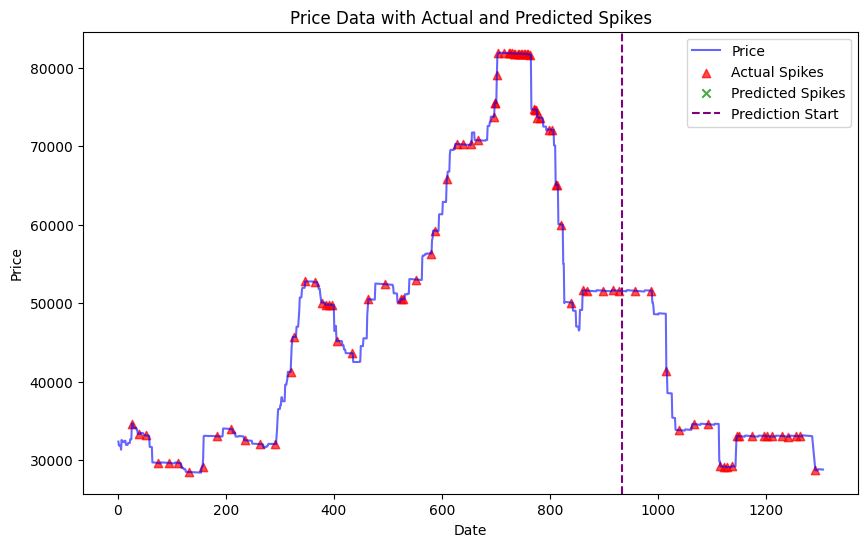

In [105]:
# Plotting the price data and spikes
plt.figure(figsize=(10, 6))
plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue', alpha=0.6)

# Highlighting actual spikes
spike_indices = aggregated_df[aggregated_df['spikes_if'] == 1].index
spike_prices = aggregated_df.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Actual Spikes', alpha=0.7)

# Highlighting predicted spikes
predicted_spike_indices = aggregated_df[aggregated_df['Predicted_Spikes'] == 1].index
predicted_spike_prices = aggregated_df.loc[predicted_spike_indices, 'Price']
plt.scatter(predicted_spike_indices, predicted_spike_prices, color='green', marker='x', label='Predicted Spikes', alpha=0.7)

# Adding a vertical line to indicate where prediction starts
prediction_start_date = aggregated_df.index[test_offset]
plt.axvline(x=prediction_start_date, color='purple', linestyle='--', label='Prediction Start')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Actual and Predicted Spikes')
plt.legend()
plt.show()


In [106]:
# Assuming spikes are labeled as 1 in 'y_test'
total_spikes_in_test = np.sum(y_test == 1)
total_data_points_in_test = y_test.shape[0]
spike_percentage_in_test = (total_spikes_in_test / total_data_points_in_test) * 100

print(f"Spike Percentage in Test Sample: {spike_percentage_in_test:.2f}%")


Spike Percentage in Test Sample: 5.63%
